# Data Exploration and Analysis

In [3]:
## Load all days into a single dataframe
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from globes import taxi_dir, days_dir, flow_dir
from multiprocessing import Pool, Process, cpu_count

## get X, y in numpy arrays from relevant data
FEATURE_COLS = [
                'pickup_day', 
                'pickup_hour', 
                'pickup_zone_taxi',
                'dropoff_zone_taxi', 
                'pickup_borough', 
                'dropoff_borough'
               ]

""" get feature and label rows from filename
"""
def get_df(filename):
    df = pd.read_csv(filename, parse_dates=['pickup_datetime', 'dropoff_datetime'])
    
    # get rid of zones that don't actually really exist
    df = df.loc[df['pickup_zone_taxi'] != -1]
    df = df.loc[df['dropoff_zone_taxi'] != -1]
    df = df.dropna()
    
    df['pickup_zone_taxi'] = df['pickup_zone_taxi'].apply(int)
    df['dropoff_zone_taxi'] = df['dropoff_zone_taxi'].apply(int)
    
    df["pickup_day"] = df['pickup_datetime'].apply(lambda t: t.weekday())
    df["pickup_hour"] = df['pickup_datetime'].apply(lambda t: t.hour)

    df = df[FEATURE_COLS]
    return df

""" get X, y in numpy arrays from relevant data
"""
def getData():
    num_cores = cpu_count()/2
    print "using " + str(num_cores) + " cores"
    pool = Pool(processes=num_cores)
    
    filenames = [os.path.join(taxi_dir, days_dir, f) for f in os.listdir(os.path.join(taxi_dir, days_dir)) if f.endswith('csv')]

    # get dataframes in parallel
    df_arr = pool.map(get_df, filenames)
    pool.terminate()
    
    # concatenate dataframe array into single df
    df = pd.concat(df_arr)

    print df.shape
    return df

df = getData()

using 28 cores
(77699460, 6)


In [10]:
## GET ZONE => NAME and ZONE => BOROUGH json 
import json

from globes import zoneIdToName, zoneIdToBorough

zoneToName = zoneIdToName()
zoneToBorough = zoneIdToBorough()

## Destination proportions

In [5]:
# given a df, return a dictionary of pickup zone id => dataframe of dropoff zones
# sorted by proportion/count
def getDestCounts(df):
    dest_dfs = {}
    pickup_zones = df.groupby('pickup_zone_taxi')
    for pickup_zone, rides in pickup_zones:
        count_df = pd.DataFrame(rides.groupby('dropoff_zone_taxi').size().rename('count'))
        count_df = count_df.sort_values(by="count", ascending=False)
        total_dropoffs = float(count_df["count"].sum())
        count_df["proportion"] = count_df["count"].apply(lambda x: x/total_dropoffs)
        
        dest_dfs[pickup_zone] = count_df
    
    return dest_dfs

# get average top dropoff zone proportion for each borough
def boroughPropMax(df):
    boroughCounts = {}
    dest_dfs = getDestCounts(df)
    
    # for each pickup zone, put the value of its top proportion 
    # dropoff zone into the appropriate borough array
    for pickup_zone in dest_dfs:
        borough = zoneToBorough[pickup_zone]
        count_df = dest_dfs[pickup_zone]
        top_proportion = count_df["proportion"].iloc[0]
        if not boroughCounts.get(borough):
            boroughCounts[borough] = [top_proportion]
        else:
            boroughCounts[borough].append(top_proportion)
    
    boroughAvgs = {}
    for borough in boroughCounts:
        avg = sum(boroughCounts[borough]) / float(len(boroughCounts[borough]))
        boroughAvgs[borough] = avg
    return boroughAvgs

# get average pickup == dropoff zone proportion for each borough
def boroughPropSame(df):
    boroughCounts = {}
    dest_dfs = getDestCounts(df)
    
    # for each pickup zone, put the value of its top proportion 
    # dropoff zone into the appropriate borough array
    for pickup_zone in dest_dfs:
        borough = zoneToBorough[pickup_zone]
        count_df = dest_dfs[pickup_zone]
        if pickup_zone not in count_df.index.values:
            continue
        top_proportion = count_df["proportion"].loc[pickup_zone]
        if not boroughCounts.get(borough):
            boroughCounts[borough] = [top_proportion]
        else:
            boroughCounts[borough].append(top_proportion)
    
    boroughAvgs = {}
    for borough in boroughCounts:
        avg = sum(boroughCounts[borough]) / float(len(boroughCounts[borough]))
        boroughAvgs[borough] = avg
    return boroughAvgs

In [7]:
# boroughAvgs = boroughPropMax(df)

print boroughPropSame(df)

{u'Staten Island': 0.58505299850603409, u'Brooklyn': 0.17057874726826691, u'Bronx': 0.19423550740359879, u'EWR': 0.98246024321796066, u'Manhattan': 0.056981141692818787, u'Queens': 0.24932409456961449}


## Strongest correlations

In [17]:
# single data frame of all destination counts
def getDestCountsDf(df):
    res = {} #(pickup_zone, dropoff_zone) => proportion of all trips starting in pickup_zone    
    dest_dfs = getDestCounts(df)
    for pickup_zone in dest_dfs:
        borough = zoneToBorough[pickup_zone]
        count_df = dest_dfs[pickup_zone]
        
        top_count = count_df["count"].iloc[0]
        dropoff_zone = count_df.index.values[0]
        if pickup_zone not in count_df.index.values or top_count < 10000 or dropoff_zone == pickup_zone:
            continue
        res[(pickup_zone, dropoff_zone, top_count)] = count_df["proportion"].iloc[0]
    
    # res loaded, sort by value
    return sorted(res.iteritems(), key=lambda (k,v): (v,k), reverse=True)
    

In [18]:
for k, v in getDestCountsDf(df):
    borough = zoneToBorough[k[0]]
    # latex format
    print "%s & %s & %s & %.4f \\\\ \hline" % (borough, zoneToName[k[0]], zoneToName[k[1]], v)
    
#     print "(" + borough + ")", k[2], str(k[0]) + ". " + zoneToName[k[0]], str(k[1]) + ". " + zoneToName[k[1]]
#     print v
#     print ""

Queens & Old Astoria & Astoria & 0.2011 \\ \hline
Queens & Elmhurst/Maspeth & Elmhurst & 0.1816 \\ \hline
Queens & Rego Park & Forest Hills & 0.1720 \\ \hline
Queens & Elmhurst & Jackson Heights & 0.1706 \\ \hline
Brooklyn & Gowanus & Park Slope & 0.1687 \\ \hline
Queens & Long Island City/Queens Plaza & Astoria & 0.1682 \\ \hline
Brooklyn & Williamsburg (North Side) & Greenpoint & 0.1530 \\ \hline
Manhattan & Central Harlem & Central Harlem North & 0.1388 \\ \hline
Manhattan & Yorkville East & Upper East Side North & 0.1367 \\ \hline
Manhattan & East Harlem South & East Harlem North & 0.1349 \\ \hline
Manhattan & Upper East Side South & Upper East Side North & 0.1335 \\ \hline
Manhattan & East Harlem North & East Harlem South & 0.1295 \\ \hline
Manhattan & Manhattan Valley & Upper West Side North & 0.1256 \\ \hline
Manhattan & Upper East Side North & Upper East Side South & 0.1226 \\ \hline
Brooklyn & Cobble Hill & Brooklyn Heights & 0.1206 \\ \hline
Manhattan & Upper West Side North 

## What's up with Baisley park?

In [10]:
## Baisley park's taxi zone id is 10
BAISLEY = 10
TIMESSQ = 230
def BaisleyPark():
    df_weekdays = df.loc[df['pickup_day'].isin([0, 1, 2, 3, 4])]
    df_weekends = df.loc[df['pickup_day'].isin([5, 6])]
    
    dest_counts1 = getDestCounts(df_weekdays)
    dest_counts2 = getDestCounts(df_weekends)
    print dest_counts1[ID]
    print dest_counts2[ID]
    
## graph hour => proportion Times Sq dropoff
def plotHours(fromID, toID):
    df_from = df.loc[df["pickup_zone_taxi"] == fromID]
    
    # each hour
    hours = [h for h in range(0, 24)]
    hour_dest_proportions = []
    for h in hours:
        df_hour = df_from.loc[df_from["pickup_hour"] == h]
        dest_counts = getDestCounts(df_hour)[fromID]
        prop = dest_counts.loc[dest_counts.index == toID].iloc[0]["proportion"]
        hour_dest_proportions.append(prop)
    
    # y = hour_dest_proportions, x = hours
    with plt.style.context('ggplot'):
        plt.plot(hours, hour_dest_proportions)
        plt.xlabel('Hour of day')
        plt.ylabel('Proportion of dropoffs \nin ' + zoneToName[toID])
        plt.title('Proportion of dropoffs \nin ' + zoneToName[toID] + ' by hour')
        plt.show()


## graph DoW => proportion Times Sq dropoff
def plotDays(fromID, toID):
    df_from = df.loc[df["pickup_zone_taxi"] == fromID]
    
    # each day of week
    days = [d for d in range(0, 7)]
    day_dest_proportions = []
    for d in days:
        df_day = df_from.loc[df_from["pickup_day"] == d]
        dest_counts = getDestCounts(df_day)[fromID]
        prop = dest_counts.loc[dest_counts.index == toID].iloc[0]["proportion"]
        day_dest_proportions.append(prop)
    
    # y = day_dest_proportions, x = days
    NUM_TO_DAY = ["Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun"]
    with plt.style.context('ggplot'):
        plt.plot(days, day_dest_proportions)
        plt.xlabel('Day of week')
        plt.xticks(range(7), NUM_TO_DAY)
        plt.ylabel('Proportion dropoffs \nin ' + zoneToName[toID])
        plt.title('Proportion dropoffs \nin ' + zoneToName[toID] + ' by day')
        plt.show()


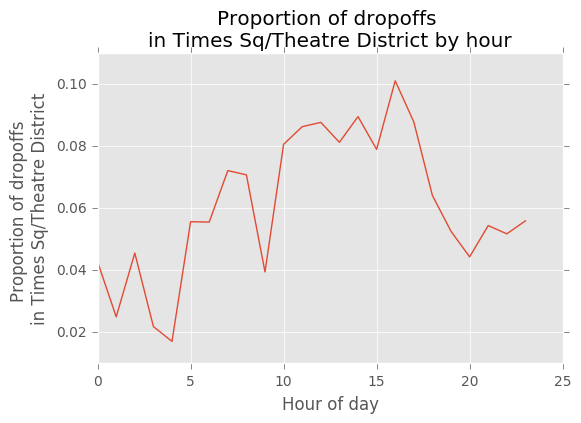

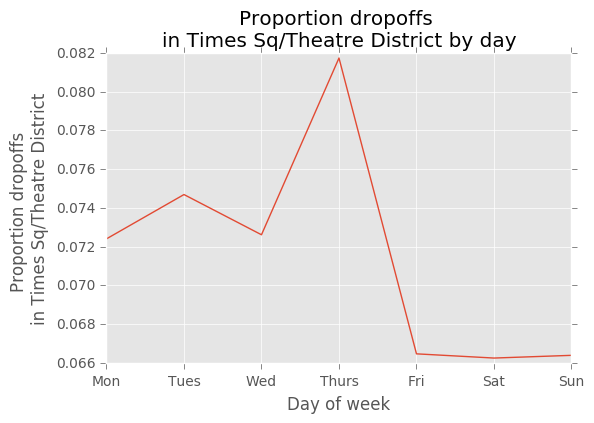

In [11]:
plotHours(BAISLEY, TIMESSQ)
plotDays(BAISLEY, TIMESSQ)


## Taxi activity, by neighborhood

In [25]:
def sortbyTotalActivity(df):
    pickups = pd.DataFrame(df.groupby('pickup_zone_taxi').size().rename('count'))
    dropoffs = pd.DataFrame(df.groupby('dropoff_zone_taxi').size().rename('count'))
    totals = pickups+dropoffs
    totals = totals.sort_values(by="count", ascending=False)
    totals["zone"] = map(lambda w: zoneToName[w], totals.index.values)
    totals["borough"] = map(lambda w: zoneToBorough[w], totals.index.values)
    return totals

In [26]:
totals = sortbyTotalActivity(df)    

In [30]:
## totals
i = 0
for row in totals.iterrows():
    print '%s & %s & %d \\\\ \hline' %(row[1]["zone"], row[1]["borough"], row[1]["count"])
    i += 1
    if i > 25:
        break

Midtown Center & Manhattan & 5055425 \\ \hline
Upper East Side North & Manhattan & 4920745 \\ \hline
Upper East Side South & Manhattan & 4876769 \\ \hline
Murray Hill & Manhattan & 4387109 \\ \hline
Midtown East & Manhattan & 4359815 \\ \hline
Times Sq/Theatre District & Manhattan & 4270514 \\ \hline
Union Sq & Manhattan & 4232954 \\ \hline
Penn Station/Madison Sq West & Manhattan & 4156720 \\ \hline
East Village & Manhattan & 4049065 \\ \hline
Clinton East & Manhattan & 3967785 \\ \hline
Lincoln Square East & Manhattan & 3622388 \\ \hline
Midtown North & Manhattan & 3484525 \\ \hline
Upper West Side South & Manhattan & 3339403 \\ \hline
East Chelsea & Manhattan & 3261387 \\ \hline
Gramercy & Manhattan & 3226753 \\ \hline
Lenox Hill West & Manhattan & 3214643 \\ \hline
Midtown South & Manhattan & 3144353 \\ \hline
West Village & Manhattan & 2698346 \\ \hline
Upper West Side North & Manhattan & 2654228 \\ \hline
LaGuardia Airport & Queens & 2627187 \\ \hline
TriBeCa/Civic Center & Manha

In [41]:
## totals, by borough
for name, group in totals.groupby("borough"):
    print "\n\n" + name
    i = 0
    for row in group.iterrows():
        print str(row[0]) + ", ",
#         print '%s & %s & %d \\\\ \hline' %(row[1]["zone"], row[1]["borough"], row[1]["count"])
        i += 1
        if i > 5:
            break



Bronx
168,  247,  69,  159,  119,  235,  

Brooklyn
181,  255,  256,  97,  112,  33,  

EWR
1,  

Manhattan
161,  236,  237,  170,  162,  230,  

Queens
138,  132,  7,  129,  82,  226,  

Staten Island
206,  221,  115,  6,  23,  245, 
